
This notebook prepares the subject-level mean distances for Liu 2019 kept subjects.

This is only the first step of the processing

There is another step of processing to add the values from set-based approach


### mean distance between HLA alleles for each subject:

    depth on Zheng 2021 positive TCRs, cor
    
    blosum62-based distance
    
the items below are left for the next notebook:
    
    depth on Zheng 2021 positive TCRs, set
    
    depth on Zheng 2021 positive TCRs, breadth

In [1]:
import pandas as pd
import numpy as np

from collections import defaultdict
from collections import Counter

import ot
import ot.plot

import matplotlib.pyplot as plt
import math

In [2]:
# load the info of subjects with HLA-I alleles under our consideration
df_liu_2019 = pd.read_csv("../results/st15_liu_2019_kept_hla_match_replace.csv", header=0)
df_liu_2019[:6]

,Unnamed: 0,total_muts,nonsyn_muts,clonal_muts,subclonal_muts,heterogeneity,total_neoantigens,CNA_prop,"gender (Male=1, Female=0)",biopsy site,...,numPriorTherapies,biopsy site_categ,biopsyContext (1=Pre-Ipi; 2=On-Ipi; 3=Pre-PD1; 4=On-PD1),daysBiopsyToPD1,daysBiopsyAfterIpiStart,purity,ploidy,hla_class_i_alleles,homozygous,hla_class_i_alleles_replace
0,Patient1,34,22,12,10,0.454545,49,0.321417,0,skin,...,1,skin,3,-84,unk,0.92,1.73,"A0201,A1101,B1801,B4402,C0501,C1203",0,"A0201,A1101,B1801,B4402,C0501,C1203"
1,Patient10,96,71,48,22,0.314286,230,0.391384,0,skin,...,2,skin,3,-12,107,0.83,1.84,"A0101,A0201,B0801,B1501,C0304,C0701",0,"A0101,A0201,B0801,B1501,C0304,C0701"
2,Patient100,200,126,98,24,0.196721,301,0.029447,0,skin,...,1,skin,3,-94,33,0.11,2.17,"A0201,A0301,B0702,B2705,C0202,C0702",0,"A0201,A0301,B0702,B2705,C0202,C0702"
3,Patient102,370,246,215,26,0.107884,825,0.169389,1,brain,...,0,brain,3,-64,na,0.70,3.24,"A0201,A2402,B0702,B1801,C0701,C0702",0,"A0201,A2402,B0702,B1801,C0701,C0702"
4,Patient104,130,96,65,28,0.301075,329,0.206518,0,lymph node,...,0,lymph node,3,-57,na,0.86,4.58,"A0201,A3001,B1302,B4901,C0602,C0701",0,"A0201,A3001,B1302,B4901,C0602,C0701"
5,Patient105,185,125,85,23,0.212963,334,0.394306,0,skin,...,0,skin,3,-22,na,0.86,2.42,"A0201,A0201,B0702,B1501,C0304,C0702",1,"A0201,A0201,B0702,B1501,C0304,C0702"


In [3]:
df_liu_2019.shape

(143, 49)

In [4]:
df_liu_2019.isna().sum()

Unnamed: 0                                                  0
total_muts                                                  0
nonsyn_muts                                                 0
clonal_muts                                                 0
subclonal_muts                                              0
heterogeneity                                               0
total_neoantigens                                           0
CNA_prop                                                    0
gender (Male=1, Female=0)                                   0
biopsy site                                                 0
monthsBiopsyPreTx                                           0
BR                                                          0
PFS                                                         0
OS                                                          0
TimeToBR                                                    0
cyclesOnTherapy                                             0
txOngoin

In [6]:
# load HLA-I distance matrix based on zheng 2021 pos tcrs or pseudo sequences

df_depth = pd.read_csv("../results/st4_zheng_2021_pos_HLA_I_dist_ensemble_20.csv", header=0)

df_blosum62 = pd.read_csv("../results/st5_blosum62_HLA_I_dist.csv", header=0)

In [7]:
print(df_depth.shape)
print(df_blosum62.shape)

(85, 85)
(85, 85)


In [8]:
hla_i_85_format = ["".join(x.split(".")[1:]) for x in df_depth.columns.tolist()]

In [9]:
# create a dictionary for the distance between any two hla i alleles

# for DePTH zheng 2021 based

depth_dict = defaultdict(float)

for i, a in enumerate(hla_i_85_format):
    cur_list = df_depth.iloc[:, i].tolist()
    for j, b in enumerate(hla_i_85_format):
        depth_dict[(a, b)] = cur_list[j]

In [10]:
# for blosum62 based 
blosum62_dict = defaultdict(float)

for i, a in enumerate(hla_i_85_format):
    cur_list = df_blosum62.iloc[:, i].tolist()
    for j, b in enumerate(hla_i_85_format):
        blosum62_dict[(a, b)] = cur_list[j]

In [11]:
# plot the distances from two lists of TCRs for the same HLA pairs

test_depth_dict_keys = list(depth_dict.keys())

test_depth_values = [depth_dict[x] for x in test_depth_dict_keys]

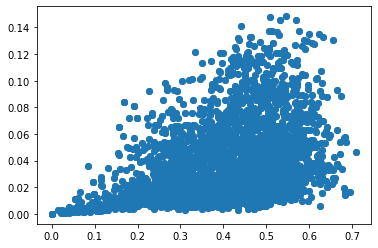

In [12]:
# plot the distances from zheng 2021 positive TCRs and blosum62 for the same HLA pairs
plt.scatter(blosum62_dict.values(), depth_dict.values())
plt.show()

In [13]:
# verify whether each subjects has two alleles for each of A, B, C
# the answer is true

genotype_list = [x.split(",") for x in df_liu_2019.hla_class_i_alleles.tolist()]

ABC_list = []

for genotype in genotype_list:
    ABC_list += ["".join([list(x)[0] for x in genotype])]

Counter(ABC_list)

Counter({'AABBCC': 143})

In [14]:
genotype_replace_list = [x.split(",") for x in df_liu_2019.hla_class_i_alleles_replace.tolist()]

ABC_replace_list = []

for genotype in genotype_replace_list:
    ABC_replace_list += ["".join([list(x)[0] for x in genotype])]

Counter(ABC_replace_list)

Counter({'AABBCC': 143})

In [15]:
# compute the distance based on both two TCR resources and pseudo sequence
# based on blosum62 for each subject

# use github_hlas_replace for depth pos

depth_aa = []
depth_bb = []
depth_cc = []

for genotype in genotype_replace_list:
    depth_aa += [depth_dict[(genotype[0], genotype[1])]]
    depth_bb += [depth_dict[(genotype[2], genotype[3])]]   
    depth_cc += [depth_dict[(genotype[4], genotype[5])]]

depth_ave = [(x+y+z)/3 for x,y,z in zip(depth_aa, depth_bb, depth_cc)]

# use HLAI_Genotype_replace for aa as well
aa_aa = []
aa_bb = []
aa_cc = []

for genotype in genotype_replace_list:
    aa_aa += [blosum62_dict[(genotype[0], genotype[1])]]
    aa_bb += [blosum62_dict[(genotype[2], genotype[3])]]   
    aa_cc += [blosum62_dict[(genotype[4], genotype[5])]]

aa_ave = [(x+y+z)/3 for x,y,z in zip(aa_aa, aa_bb, aa_cc)]

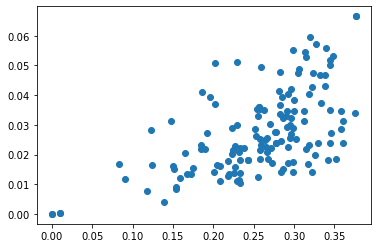

In [16]:
plt.scatter(aa_ave, depth_ave)
plt.show()

In [17]:
df_liu_2019["depth_ave"] = depth_ave
df_liu_2019["aa_ave"] = aa_ave

In [18]:
df_liu_2019.isna().sum()

Unnamed: 0                                                  0
total_muts                                                  0
nonsyn_muts                                                 0
clonal_muts                                                 0
subclonal_muts                                              0
heterogeneity                                               0
total_neoantigens                                           0
CNA_prop                                                    0
gender (Male=1, Female=0)                                   0
biopsy site                                                 0
monthsBiopsyPreTx                                           0
BR                                                          0
PFS                                                         0
OS                                                          0
TimeToBR                                                    0
cyclesOnTherapy                                             0
txOngoin

In [19]:
# save the extended df_liu_2019 file out
df_liu_2019.to_csv("../results/st16_liu_2019_depth_aa_scores.csv", index = False)